In [ ]:
import numpy as np

import cv2

import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch

from tqdm import tqdm

import models.BaseModel as BaseModel

In [2]:
device = (torch.device(f"cuda:0") if torch.cuda.is_available() else torch.device("cpu"))

# 1. Посмотрим на данные

In [3]:
transform = transforms.ToTensor()

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=True, num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=0
)

In [5]:
def plot_images(random_batch, k):
    images, labels = random_batch
    for index in range(k):
        image, label = random_batch[0][index], random_batch[1][index]
        plt.figure()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(f"Image label: {label}")

def get_predictions(model, eval_data, step=10):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim = 1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim = 1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score

Размерность: torch.Size([3, 32, 32])


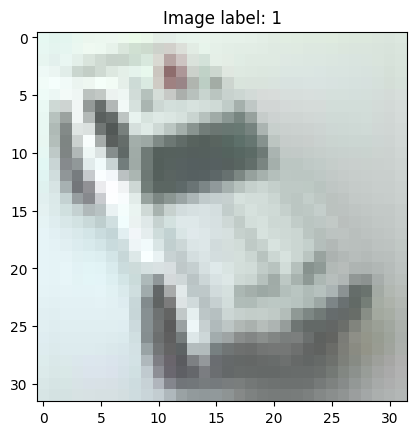

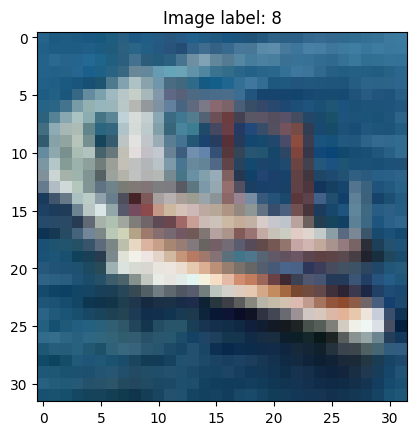

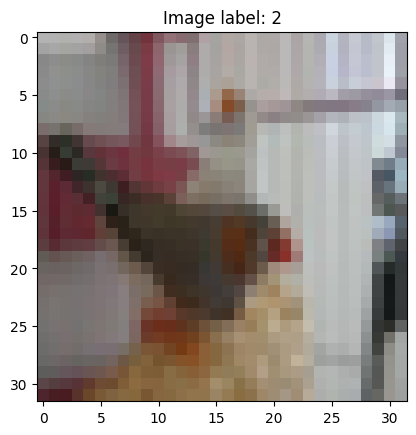

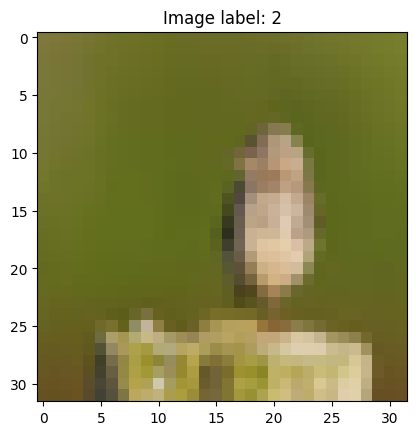

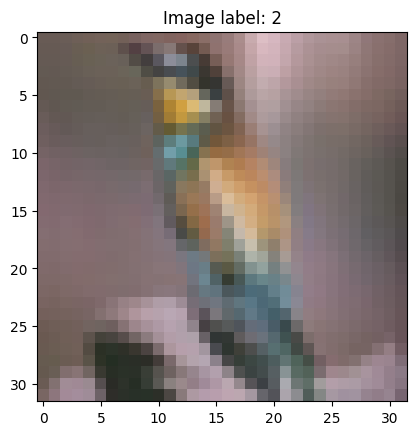

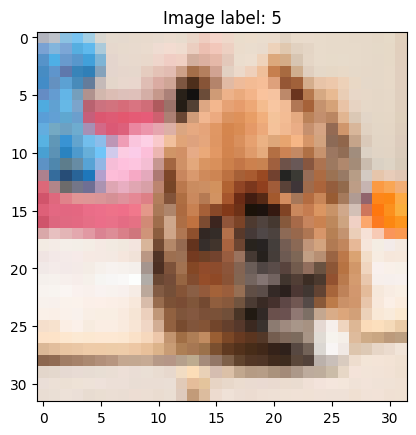

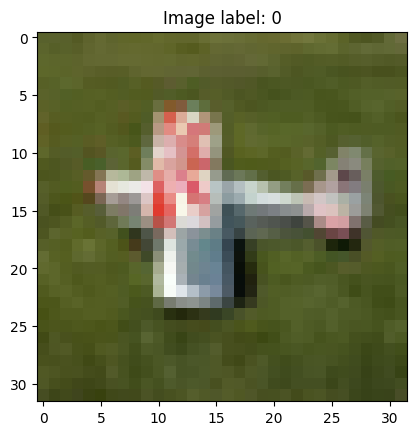

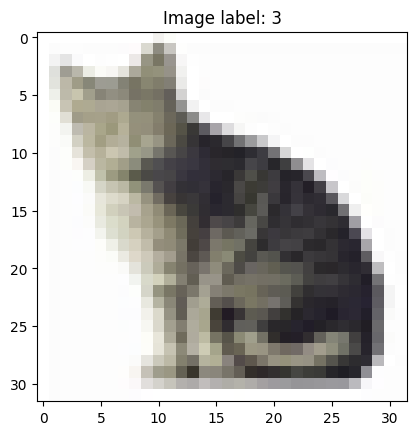

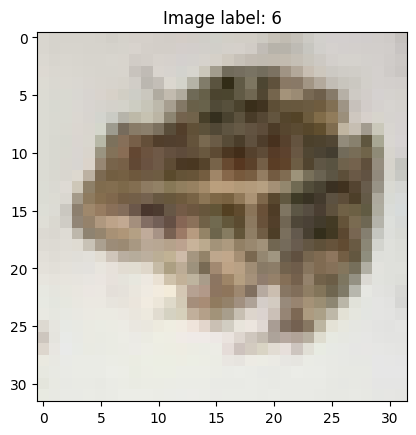

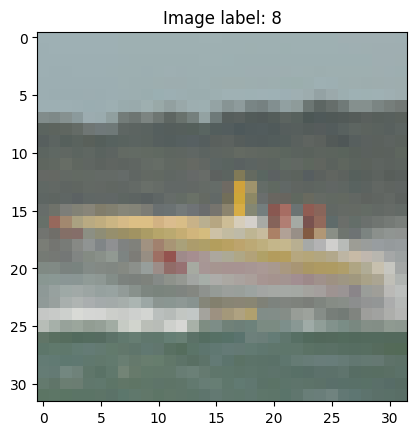

In [6]:
k = 10

random_batch = next(iter(train_data_loader))
plot_images(random_batch, k)

print("Размерность:", random_batch[0][k].shape)

# 2. Обучим базовую модель

In [7]:
Model_1 = BaseModel.BaseModel()

In [8]:
Model_1.train_model(train_data_loader, device, val_data_loader = val_data_loader, num_epoches = 50)

100%|██████████| 50/50 [14:24<00:00, 17.29s/it]


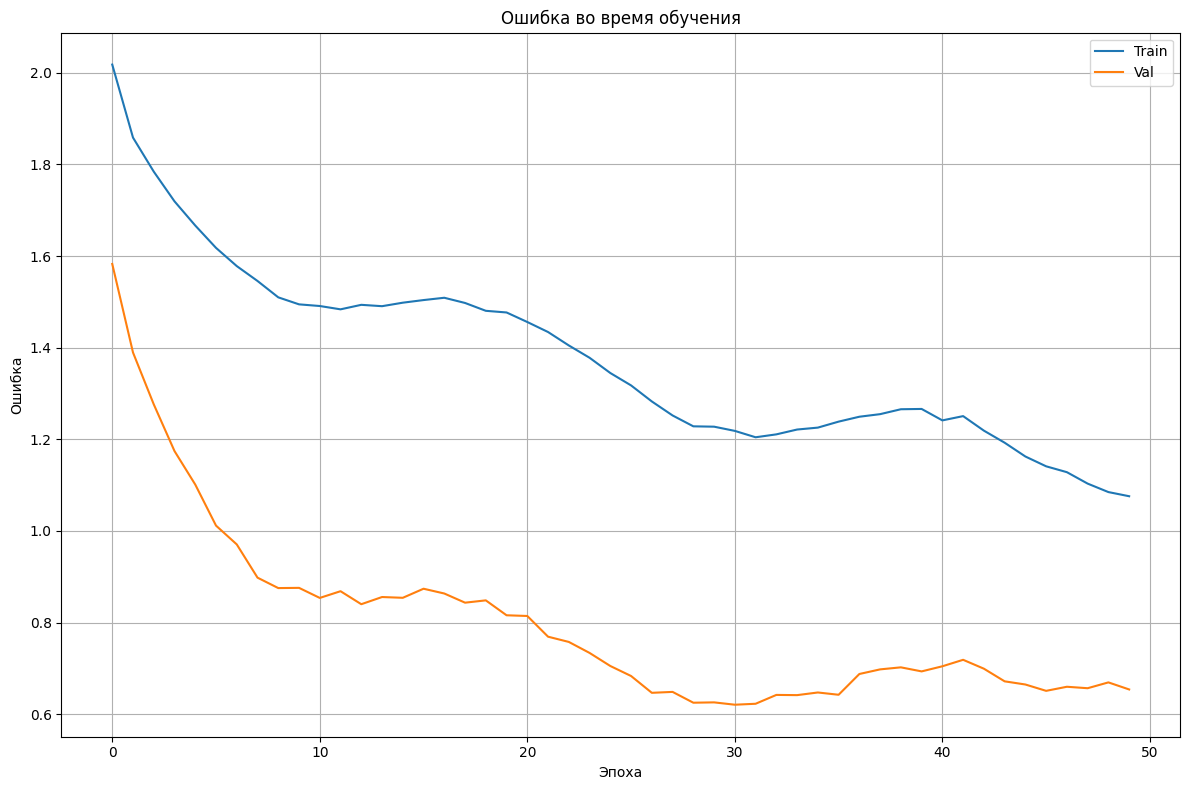

In [9]:
Model_1.plot_loss()

In [10]:
Model_1_train_accuracy = get_accuracy(Model_1, train_data_loader)
Model_1_val_accuracy = get_accuracy(Model_1, val_data_loader)

print("Точность на обучающей выборке:", Model_1_train_accuracy)
print("Точность на валидационной выборке:", Model_1_val_accuracy)

Точность на обучающей выборке: tensor(0.9955)
Точность на валидационной выборке: tensor(0.7796)


In [11]:
torch.save(Model_1.state_dict(), 'models/model_1_w.pth')
torch.save(Model_1, 'models/model_1.pth')

### Модель быстро переобучается, но качество на валидации уже неплохое - точность 78%.

# 3. Аугментации!

In [12]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

train_dataset = CIFAR10(
    root='./data', 
    train=True,
    download=False, 
    transform=train_transform  
)

test_dataset = CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=test_transform
)

train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=True, num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=0
)

In [13]:
Model_2 = BaseModel.BaseModel()

In [14]:
Model_2.train_model(train_data_loader, device, val_data_loader = val_data_loader, num_epoches = 120)

100%|██████████| 120/120 [29:31<00:00, 14.76s/it]


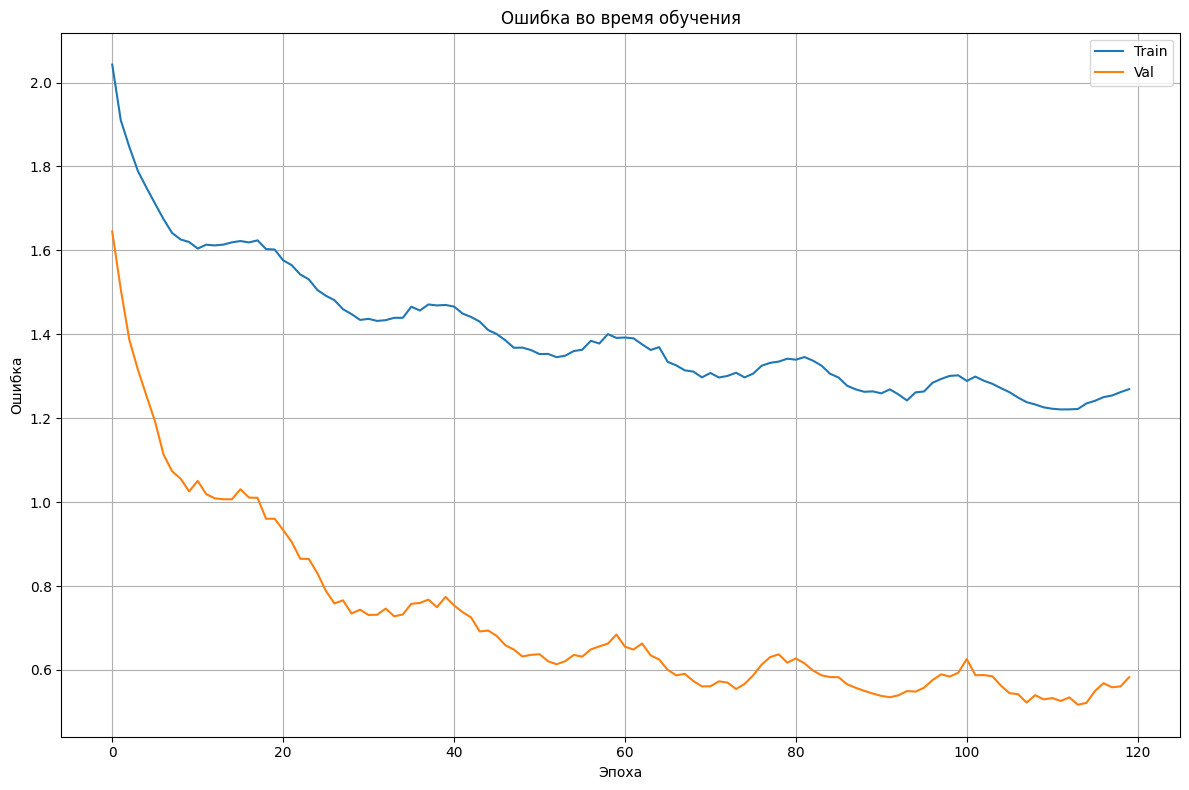

In [15]:
Model_2.plot_loss()

In [16]:
Model_2_train_accuracy = get_accuracy(Model_2, train_data_loader)
Model_2_val_accuracy = get_accuracy(Model_2, val_data_loader)

print("Точность на обучающей выборке:", Model_2_train_accuracy)
print("Точность на валидационной выборке:", Model_2_val_accuracy)

Точность на обучающей выборке: tensor(0.9199)
Точность на валидационной выборке: tensor(0.8088)


In [17]:
torch.save(Model_2.state_dict(), 'models/model_2_w.pth')
torch.save(Model_2, 'models/model_2.pth')

### Добились точности 80.9% на валидации. Еще лучше, но недостаточно

### Перейдем к Transfer Learning, там сразу используем нормированные данные